# Data Analysis for Python

Python is a powerful data analysis platform, and is a common programming language in scientific computing applications. 

Python itself confers several advantages for scientific computing:

In addition, the rich third-party library ecosystem (the "Scientific Stack") for Python extends the language to perform a wide variety of general and specific scientific computing tasks.

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
data_url = 'https://www.ncdc.noaa.gov/cag/time-series/global/globe/land/all/1/1880-2015.csv'

```
Global Land Temperature Anomalies
Units: Degrees Celsius
Base Period: 1901-2000
Year,Value
188001,-0.1538
188002,-0.5771
188003,-0.7250
188004,-0.2990
188005,-0.2098
188006,-0.3002
```

In [4]:
raw_data = pd.read_csv(data_url, skiprows=3)
raw_data.head()

,Year,Value
0,188001,-0.1419
1,188002,-0.5534
2,188003,-0.7064
3,188004,-0.2865
4,188005,-0.1968


In [5]:
raw_data.shape

(1632, 2)

In [6]:
temp_anomaly = raw_data.set_index('Year')

temp_anomaly.head()

,Value
Year,
188001,-0.1419
188002,-0.5534
188003,-0.7064
188004,-0.2865
188005,-0.1968


In [7]:
%matplotlib inline
import matplotlib.pylab as plt

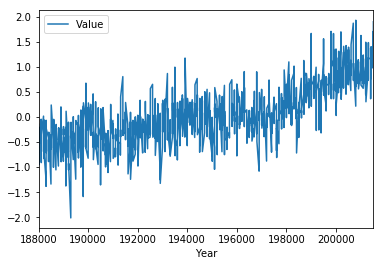

In [8]:
temp_anomaly.plot()

The index does not consist of consecutive integers:

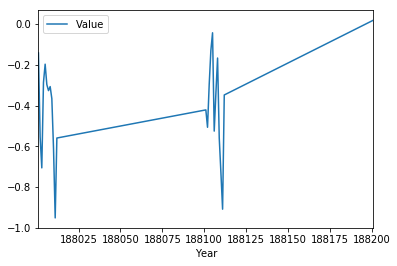

In [9]:
temp_anomaly[:25].plot()

In [10]:
n_years = 2015 - 1880 + 1

In [11]:
month_range = pd.date_range('1880-01-01', periods=temp_anomaly.shape[0], freq='M')
month_range

DatetimeIndex(['1880-01-31', '1880-02-29', '1880-03-31', '1880-04-30',
               '1880-05-31', '1880-06-30', '1880-07-31', '1880-08-31',
               '1880-09-30', '1880-10-31',
               ...
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31'],
              dtype='datetime64[ns]', length=1632, freq='M')

In [73]:
temp_anomaly = (raw_data.set_index(month_range)
                          .drop('Year', axis=1)
                          .rename(columns={'Value':'Anomaly'}))
temp_anomaly.head()

,Anomaly
1880-01-31,-0.1419
1880-02-29,-0.5534
1880-03-31,-0.7064
1880-04-30,-0.2865
1880-05-31,-0.1968


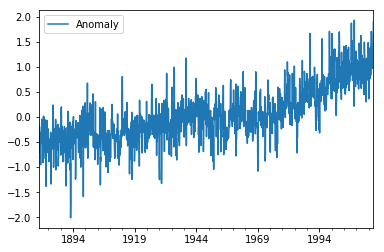

In [74]:
temp_anomaly.plot()

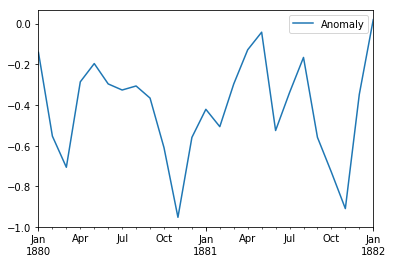

In [75]:
temp_anomaly[:25].plot()

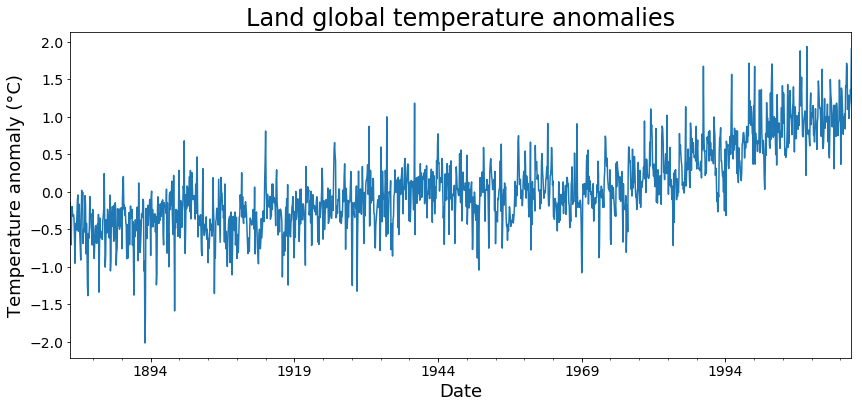

In [78]:
axes = temp_anomaly.plot(figsize=(14,6), legend=False, fontsize=14)
axes.set_title('Land global temperature anomalies', fontsize=24)
axes.set_ylabel('Temperature anomaly (°C)', fontsize=18)
axes.set_xlabel('Date', fontsize=18)

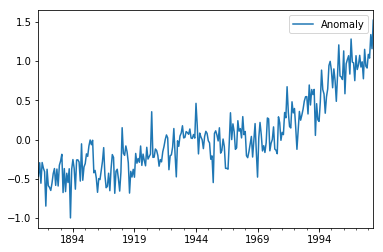

In [79]:
temp_anomaly.resample('2Q').mean().plot()

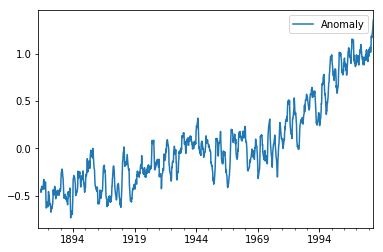

In [80]:
temp_anomaly.rolling(12).mean().plot()

In [81]:
from sklearn import linear_model

In [82]:
x_grid = np.arange(temp_anomaly.shape[0])
regmod = linear_model.LinearRegression()
regmod.fit(X=x_grid.reshape(-1,1), y=temp_anomaly)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [83]:
prediction = regmod.predict(x_grid.reshape(-1,1))
prediction

array([[-0.66002704],
       [-0.65916443],
       [-0.65830182],
       ..., 
       [ 0.74516003],
       [ 0.74602264],
       [ 0.74688525]])

In [84]:
prediction = pd.Series(prediction.flatten(), index=temp_anomaly.index)

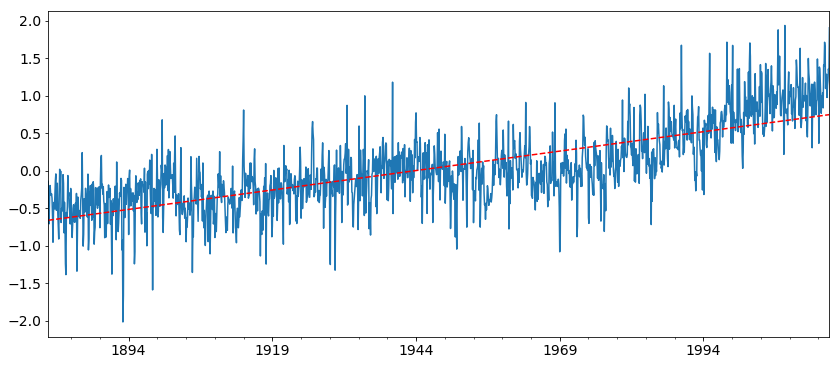

In [85]:
axes = temp_anomaly.plot(figsize=(14,6), legend=False, fontsize=14)
prediction.plot(ax=axes, style='--', color='red')

In [86]:
import pymc3 as pm
from theano import shared

x = shared(x_grid)
y = shared(temp_anomaly.Anomaly.values)

In [87]:
with pm.Model() as model:
    
    # Prior distributions
    intercept = pm.Normal('intercept', mu=0, sd=100)
    early_slope = pm.Normal('early_slope', mu=0, sd=100)
    late_slope = pm.Normal('late_slope', mu=0, sd=100)
    σ = pm.Uniform('σ', 0, 100)
    
    # Switchpoint
    τ = pm.DiscreteUniform('τ', 0, x_grid.max())
    
    # Early and late phase means
    μ_early = intercept + (x[:τ] - τ)*early_slope
    μ_late = intercept + (x[τ:] - τ)*late_slope
    
    # Data likelihoods
    pm.Normal('early_likelihood', μ_early, sd=σ, observed=y[:τ])
    pm.Normal('late_likelihood', μ_late, sd=σ, observed=y[τ:])

In [88]:
with model:
    trace = pm.sample(10000)

Assigned NUTS to intercept
Assigned NUTS to early_slope
Assigned NUTS to late_slope
Assigned NUTS to σ_interval_
Assigned Metropolis to τ
100%|██████████| 10000/10000 [01:17<00:00, 128.72it/s]


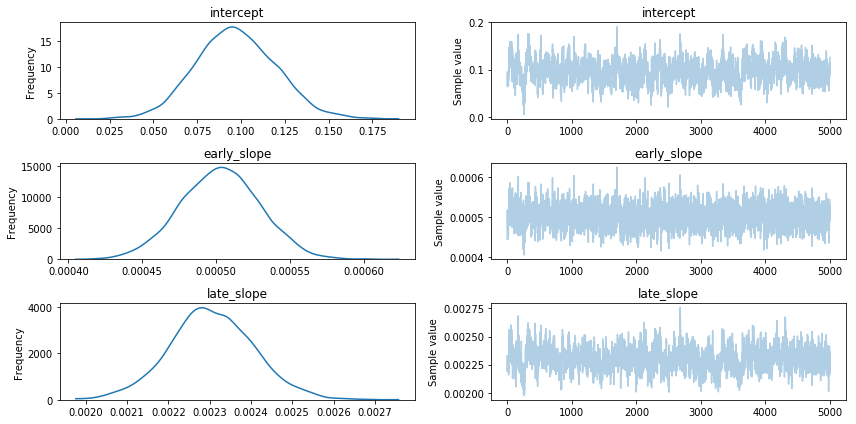

In [89]:
pm.traceplot(trace[5000:], varnames=['intercept', 'early_slope', 'late_slope']);

In [90]:
b = trace['intercept'].mean()
m1 = trace['early_slope'].mean()
m2 = trace['late_slope'].mean()
switch = int(trace['τ'].mean())

In [91]:
prediction = b + (x_grid-switch)*m1
prediction[switch:] = (b + (x_grid-switch)*m2)[switch:]
temp_anomaly['prediction'] = prediction

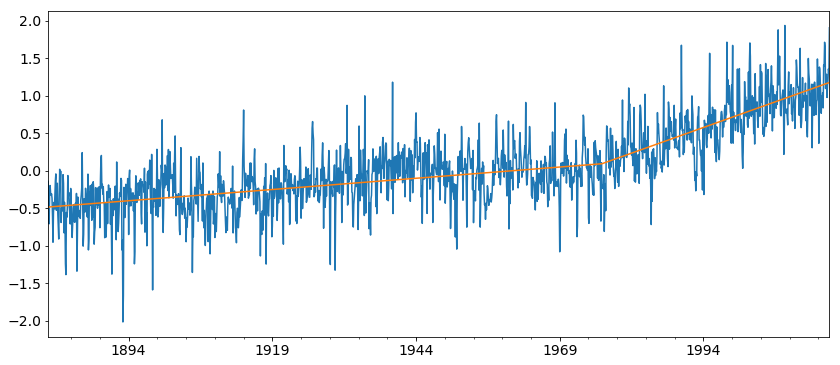

In [95]:
axes = temp_anomaly.plot(figsize=(14,6), legend=False, fontsize=14)
axes.plot(temp_anomaly.prediction)

Gaussian process model

In [106]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct

In [138]:
kernel = DotProduct() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [139]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=DotProduct(sigma_0=1) + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [140]:
y_pred, sigma = gp.predict(X, return_std=True)

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


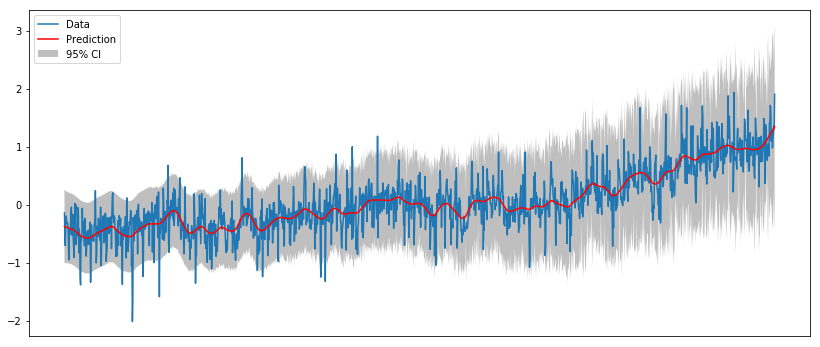

In [141]:
plt.figure(figsize=(14,6))
plt.plot(x_grid, temp_anomaly.Anomaly.values, label='Data')
plt.plot(x_grid, y_pred, color='red', label='Prediction')
plt.fill(np.concatenate([x_grid, x_grid[::-1]]),
         np.concatenate([y_pred - 2*sigma,
                        (y_pred + 2*sigma)[::-1]]),
         alpha=.5, fc='grey', ec='None', label='95% CI')
plt.xticks([])
plt.legend(loc='upper left');

## References

This work was derived from [The Python Scientific Stack](https://barbagroup.github.io/essential_skills_RRC/jupyter/1/) by L.A. Barba, N.C. Clementi, G.F. Forsyth (2016).